# Required Capstone Component 14.1


## New Information
- Decided to look at median distance rather than closest distance - because a point could be close to one point that's very far away, and then the closest distance will make it look like I'm not choosing a point in an area with very little information.

## Old Information
From my one-on-one, I have the following tips:
- $\kappa = 1$ will balance exploration and exploitation (https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)
- Checked posterior standard deviation - high standard deviation suggests that I should choose $\kappa$ to prioritise exploration. 
- I used the coefficient of variation to check whether my standard deviation was high or not (https://www.statology.org/what-is-a-good-standard-deviation/#:~:text=CV:%201%202%20%2C%200%200,the%20data%20is%20quite%20low.)
- I used latinHypercube to get samples for my GP for dimensions 4 and higher.

## Import Data

In [90]:
# Import any necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern
from scipy.stats import norm
from statistics import mean
from scipy.stats import qmc
import itertools
import math
import ast
from scipy.spatial.distance import pdist, squareform


# load initial inputs
x_1 = np.load("updated_data/week_14/function_1/inputs_week_14.npy")
x_2 = np.load("updated_data/week_14/function_2/inputs_week_14.npy")
x_3 = np.load("updated_data/week_14/function_3/inputs_week_14.npy")
x_4 = np.load("updated_data/week_14/function_4/inputs_week_14.npy")
x_5 = np.load("updated_data/week_14/function_5/inputs_week_14.npy")
x_6 = np.load("updated_data/week_14/function_6/inputs_week_14.npy")
x_7 = np.load("updated_data/week_14/function_7/inputs_week_14.npy")
x_8 = np.load("updated_data/week_14/function_8/inputs_week_14.npy")

# load initial outputs
y_1 = np.load("updated_data/week_14/function_1/outputs_week_14.npy")
y_2 = np.load("updated_data/week_14/function_2/outputs_week_14.npy")
y_3 = np.load("updated_data/week_14/function_3/outputs_week_14.npy")
y_4 = np.load("updated_data/week_14/function_4/outputs_week_14.npy")
y_5 = np.load("updated_data/week_14/function_5/outputs_week_14.npy")
y_6 = np.load("updated_data/week_14/function_6/outputs_week_14.npy")
y_7 = np.load("updated_data/week_14/function_7/outputs_week_14.npy")
y_8 = np.load("updated_data/week_14/function_8/outputs_week_14.npy")


In [91]:
x_new = [np.array([0.646465, 0.969697]), 
np.array([0.707071, 0.929293]), 
np.array([0.484848, 0.767677, 0.000000]), 
np.array([00.390749, 0.379940, 0.454619, 0.424190]), 
np.array([0.185689, 0.876142, 0.938525, 0.911330]), 
np.array([0.380210, 0.273190, 0.561698, 0.585146, 0.007805]), 
np.array([0.002921, 0.380605, 0.132162, 0.112541, 0.335804, 0.806594]), 
np.array([0.018646, 0.243670, 0.003088, 0.341666, 0.765396, 0.568567, 0.258959, 0.382488])]


y_new = [np.float64(5.669846173692881e-82), 
np.float64(0.6568101438764611), 
np.float64(-0.13890800696030067), 
np.float64(-0.28412881132717116), 
np.float64(1767.0906320261333), 
np.float64(-0.46406427080583296), 
np.float64(1.2066228516719926), 
np.float64(9.8759495354066)]


print(x_new)
print(y_new)

print(type(x_new))
print(type(y_new))

print(x_new[2]) 
print(y_new[2])








[array([0.646465, 0.969697]), array([0.707071, 0.929293]), array([0.484848, 0.767677, 0.      ]), array([0.390749, 0.37994 , 0.454619, 0.42419 ]), array([0.185689, 0.876142, 0.938525, 0.91133 ]), array([0.38021 , 0.27319 , 0.561698, 0.585146, 0.007805]), array([0.002921, 0.380605, 0.132162, 0.112541, 0.335804, 0.806594]), array([0.018646, 0.24367 , 0.003088, 0.341666, 0.765396, 0.568567,
       0.258959, 0.382488])]
[np.float64(5.669846173692881e-82), np.float64(0.6568101438764611), np.float64(-0.13890800696030067), np.float64(-0.28412881132717116), np.float64(1767.0906320261333), np.float64(-0.46406427080583296), np.float64(1.2066228516719926), np.float64(9.8759495354066)]
<class 'list'>
<class 'list'>
[0.484848 0.767677 0.      ]
-0.13890800696030067


## Create Functions


In [92]:
from pickle import NONE
from statistics import median


def find_median_neighbor_distances(points):
    """
    Find the median distance from each point to its neighbors.
    
    Args:
        points: numpy array of shape (n_points, n_dimensions)
    
    Returns:
        distances: array of median distances to neighbors for each point
    """
    # Compute pairwise distances
    distances_matrix = squareform(pdist(points))
    
    # Set diagonal to infinity to exclude self-distances
    np.fill_diagonal(distances_matrix, np.inf)
    
    # Find minimum distance for each point (closest neighbor)
    median_distances = np.median(distances_matrix, axis=1)
    
    return median_distances



def find_median_distance_to_array(single_point, array_of_points):
    """
    Find the median distance from a single point to an array of points.
    
    Args:
        single_point: numpy array of shape (n_dimensions,)
        array_of_points: numpy array of shape (n_points, n_dimensions)
    
    Returns:
        median_distance: scalar, median distance
    """
    # Calculate distances from single point to all points in array
    distances = np.sqrt(np.sum((array_of_points - single_point)**2, axis=1))
    
    # Find median distance and its index
    median_distance = np.median(distances)
    
    return median_distance




def plot_boxplot_with_new_point(data, new_query_point, old_query_point, title="Boxplot with New Point", 
                                ylabel="nearest neighbor distance",
                               new_point_label=None, figsize=(10, 6), overlay=False):
    """
    Create a boxplot with a new point overlaid in red.

    Parameters:
    -----------
    data : array-like
        The data to create the boxplot from
    new_data : float
        The new point value to overlay
    title : str, optional
        Title for the plot (default: "Boxplot with New Point")
    ylabel : str, optional
        Label for y-axis (default: "nearest neighbor distance")
    new_point_label : str, optional
        Custom label for the new point (default: auto-generated)
    figsize : tuple, optional
        Figure size (default: (10, 6))
    overlay : bool, optional
        If True, overlay each data point on top of the boxplot in a light colour
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # Create figure
    plt.figure(figsize=figsize)
    
    # Create the boxplot
    box_plot = plt.boxplot(data, patch_artist=True)
    
    # Style the boxplot
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][0].set_alpha(0.7)
    
    # Optionally overlay all data points in a light colour
    if overlay:
        x_jitter = np.random.normal(0, 0.03, size=len(data))
        x_positions = 1 + x_jitter
        plt.scatter(x_positions, data, color='#7f8c8d', alpha=0.4, s=30, zorder=4, label='_nolegend_')
    
    # add new data: 
    for i in range(len(old_query_point)):
        # Convert old_query_point to float if it's numpy type
        new_value = float(old_query_point[i])
    
        # Add the new point in blue
        plt.scatter(1, new_value, color='blue', s=100, zorder=5, label="Previous Query Points")
    
        # Add value label for the new point
        plt.annotate(f'{new_value:.6e}', 
                    xy=(1, new_value), 
                    xytext=(1.1, new_value),
                    arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
                    fontsize=10, 
                    color='blue',
                    ha='left')

    
    # Convert old_query_point to float if it's numpy type
    new_value = float(new_query_point[0])
    
    # Add the new point in red
    plt.scatter(1, new_value, color='red', s=100, zorder=5, label="New Query Point")
    
    # Add value label for the new point
    plt.annotate(f'{new_value:.6e}', 
                xy=(1, new_value), 
                xytext=(1.1, new_value),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, 
                color='red',
                ha='left')
    
    # Customize the plot
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Show the plot
    plt.show()




def plot_boxplot(data, 
                title="Boxplot with New Point", 
                ylabel="nearest neighbor distance",
                figsize=(10, 6)):
    """
    Create a boxplot with a new point overlaid in red.
    
    Parameters:
    -----------
    data : array-like
        The data to create the boxplot from
    title : str, optional
        Title for the plot (default: "Boxplot with New Point")
    ylabel : str, optional
        Label for y-axis (default: "nearest neighbor distance")
    figsize : tuple, optional
        Figure size (default: (10, 6))
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    plt.figure(figsize=figsize)
    plt.boxplot(data, vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.6))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()




# Replace your grid code with Latin Hypercube Sampling
def create_lhs_grid(n_samples, n_dimensions, seed=42):
    """
    Create Latin Hypercube Sampling grid.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples 
    n_dimensions : int
        Number of dimensions 
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    numpy array of shape (n_samples, n_dimensions)
    """
    # Create Latin Hypercube sampler
    sampler = qmc.LatinHypercube(d=n_dimensions, seed=seed)
    
    # Generate samples in [0, 1]^d
    samples = sampler.random(n=n_samples)
    
    return samples


## Compare Old Values to New

### Function 1

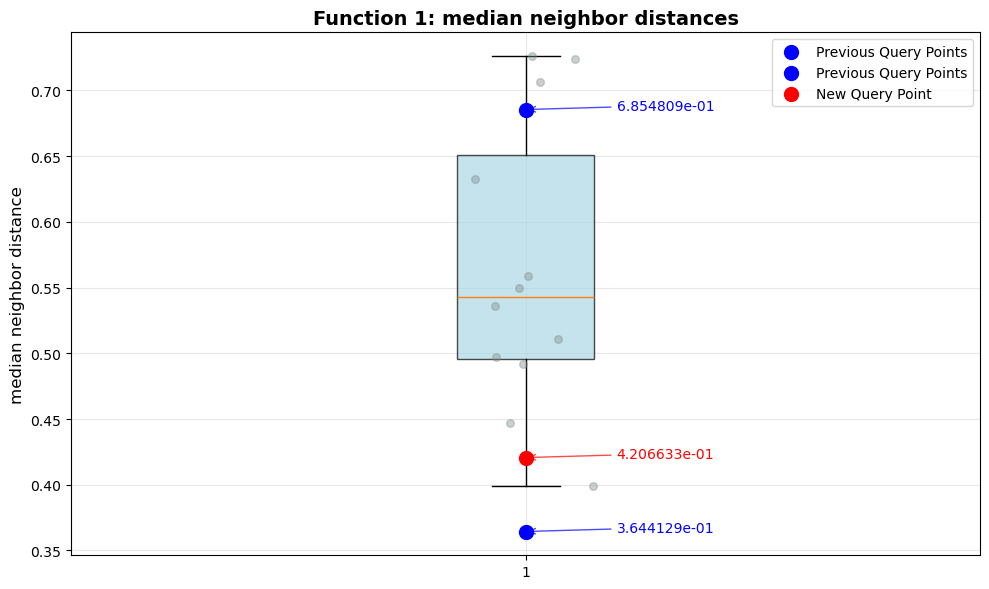

In [93]:
x1_distances = find_median_neighbor_distances(np.array(x_1))
new_x1_distance = np.array([find_median_distance_to_array(x_new[0], np.array(x_1))])
old_x1_distance = np.array([find_median_distance_to_array(x_1[-2], np.array(x_1)), find_median_distance_to_array(x_1[-1], np.array(x_1))])

plot_boxplot_with_new_point(
    x1_distances, 
    new_x1_distance,
    old_x1_distance, 
    'Function 1: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

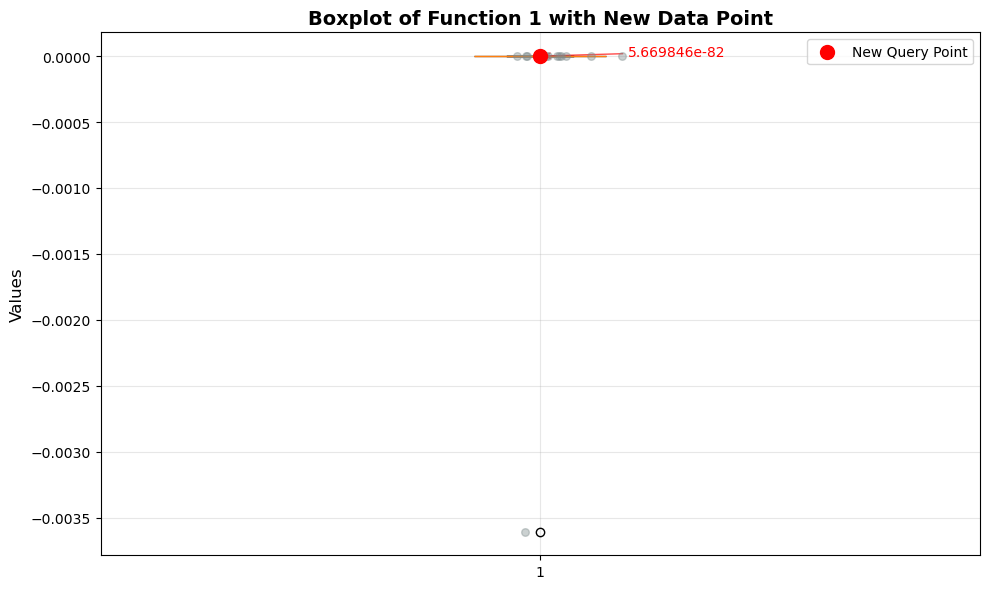

Old maximum: 7.710875e-16
New point: 5.669846e-82
Percentile rank in y_1: 41.7%

Old position: [0.73102363 0.73299988]
New position: [0.646465 0.969697]


In [ ]:

plot_boxplot_with_new_point(
    y_1, 
    [y_new[0]], 
    np.array([]), # data very skew, so leave out old points
    'Boxplot of Function 1 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_1):.6e}")
print(f"New point: {y_new[0]:.6e}")
print(f"Percentile rank in y_1: {100 * (y_1 < y_new[0]).sum() / len(y_1):.1f}%")
print(f"\nOld position: {x_1[np.argmax(y_1)]}")
print(f"New position: {x_new[0]}")

### Function 2

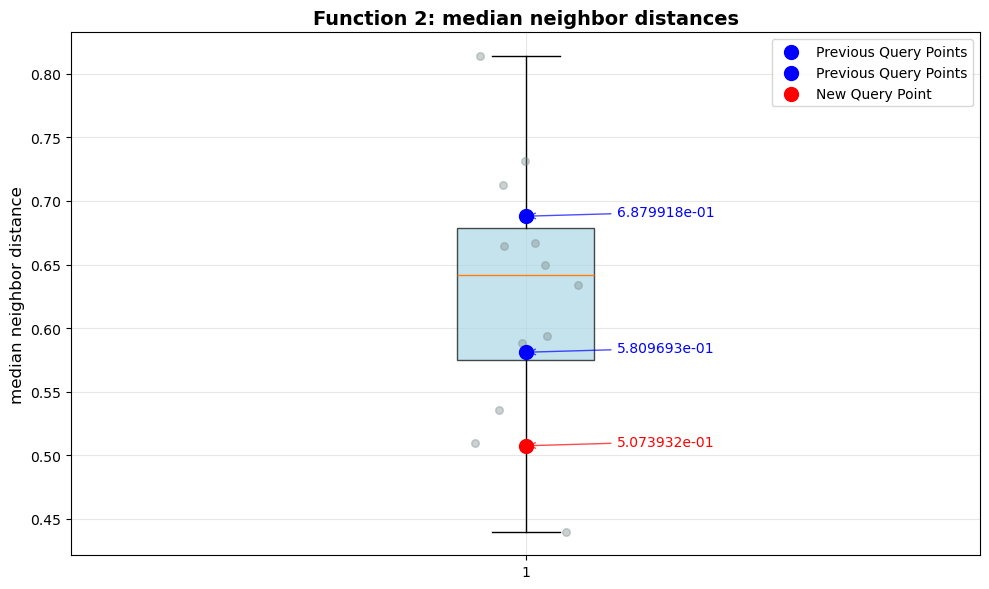

In [ ]:
x2_distances = find_median_neighbor_distances(np.array(x_2))
new_x2_distance = np.array([find_median_distance_to_array(x_new[1], np.array(x_2))])
old_x2_distance = np.array([find_median_distance_to_array(x_2[-2], np.array(x_2)), find_median_distance_to_array(x_2[-1], np.array(x_2))])

plot_boxplot_with_new_point(
    x2_distances, 
    new_x2_distance,
    old_x2_distance, 
    'Function 2: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)


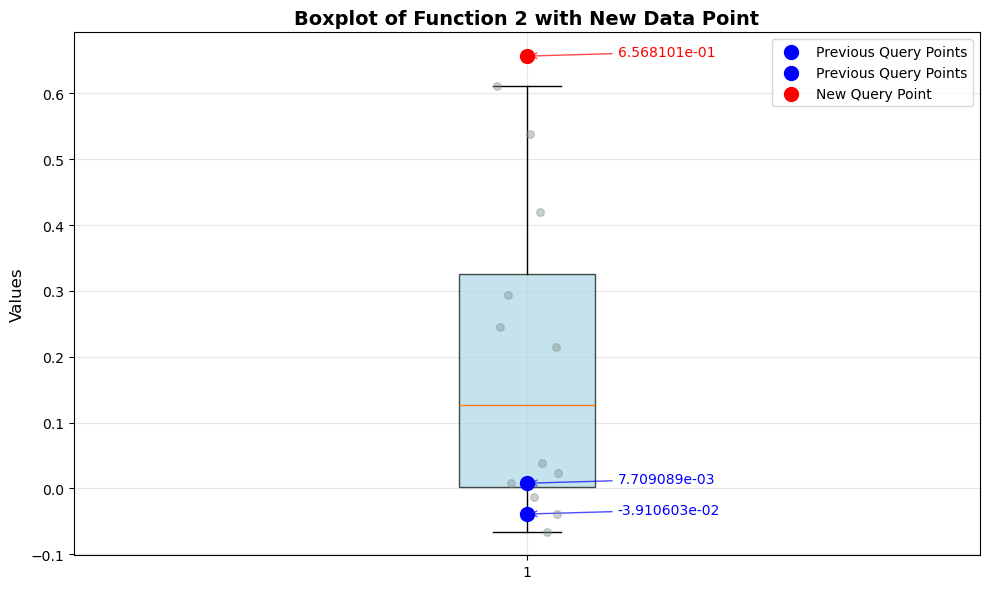

Old maximum: 6.112052e-01
New point: 6.568101e-01
Percentile rank in y_2: 100.0%

Old position: [0.70263656 0.9265642 ]
New position: [0.707071 0.929293]


In [116]:

plot_boxplot_with_new_point(
    y_2, 
    [y_new[1]], 
    np.array([y_2[-2], y_2[-1]]), 
    'Boxplot of Function 2 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_2):.6e}")
print(f"New point: {y_new[1]:.6e}")
print(f"Percentile rank in y_2: {100 * (y_2 < y_new[1]).sum() / len(y_2):.1f}%")
print(f"\nOld position: {x_2[np.argmax(y_2)]}")
print(f"New position: {x_new[1]}")

### Function 3

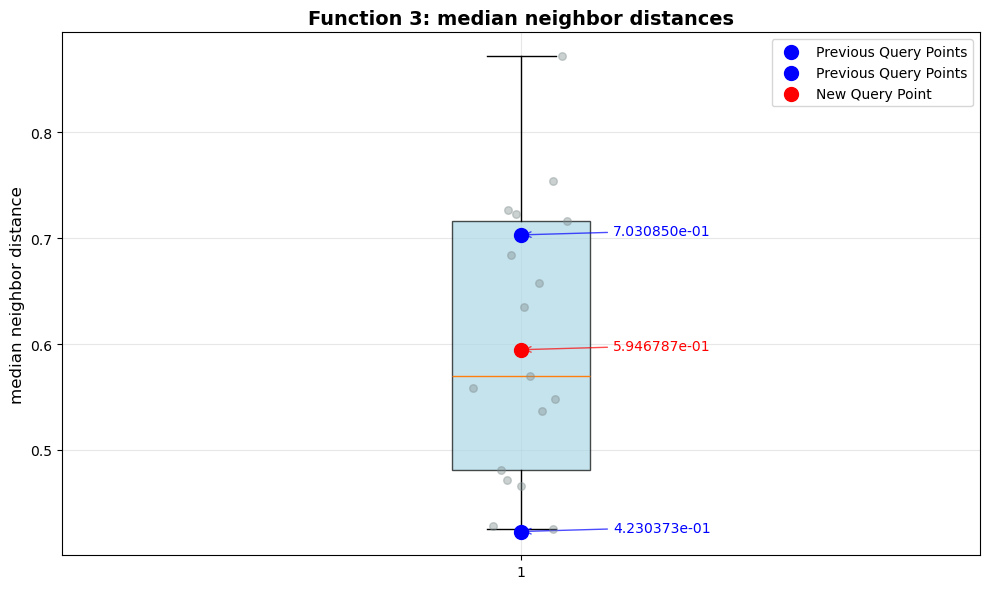

In [108]:
x3_distances = find_median_neighbor_distances(np.array(x_3))
new_x3_distance = np.array([find_median_distance_to_array(x_new[2], np.array(x_3))])
old_x3_distance = np.array([find_median_distance_to_array(x_3[-2], np.array(x_3)), find_median_distance_to_array(x_3[-1], np.array(x_3))])

plot_boxplot_with_new_point(
    x3_distances, 
    new_x3_distance,
    old_x3_distance, 
    'Function 3: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

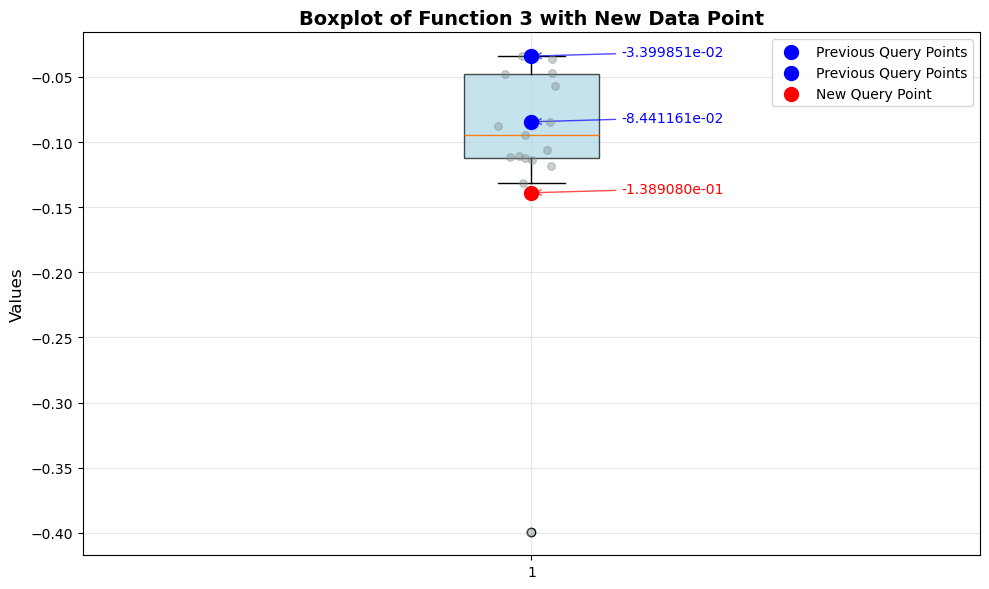

Old maximum: -3.399851e-02
New point: -1.389080e-01
Percentile rank in y_3: 5.9%

Old position: [0.323232 0.282828 0.454545]
New position: [0.484848 0.767677 0.      ]


In [117]:
plot_boxplot_with_new_point(
    y_3, 
    [y_new[2]], 
    np.array([y_3[-2], y_3[-1]]), 
    'Boxplot of Function 3 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_3):.6e}")
print(f"New point: {y_new[2]:.6e}")
print(f"Percentile rank in y_3: {100 * (y_3 < y_new[2]).sum() / len(y_3):.1f}%")
print(f"\nOld position: {x_3[np.argmax(y_3)]}")
print(f"New position: {x_new[2]}")

### Function 4

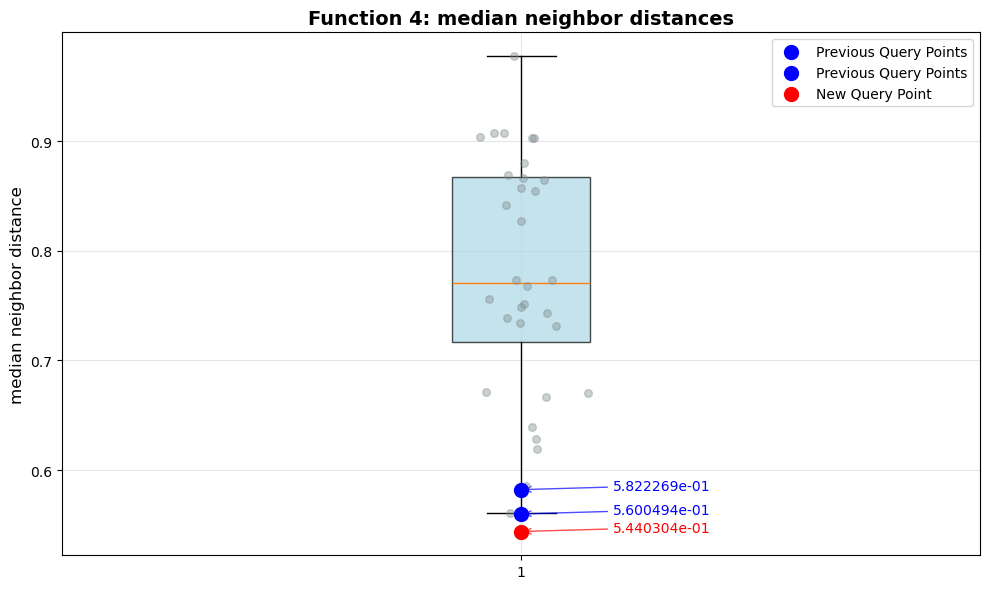

In [109]:
x4_distances = find_median_neighbor_distances(np.array(x_4))
new_x4_distance = np.array([find_median_distance_to_array(x_new[3], np.array(x_4))])
old_x4_distance = np.array([find_median_distance_to_array(x_4[-2], np.array(x_4)), find_median_distance_to_array(x_4[-1], np.array(x_4))])

plot_boxplot_with_new_point(
    x4_distances, 
    new_x4_distance,
    old_x4_distance, 
    'Function 4: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

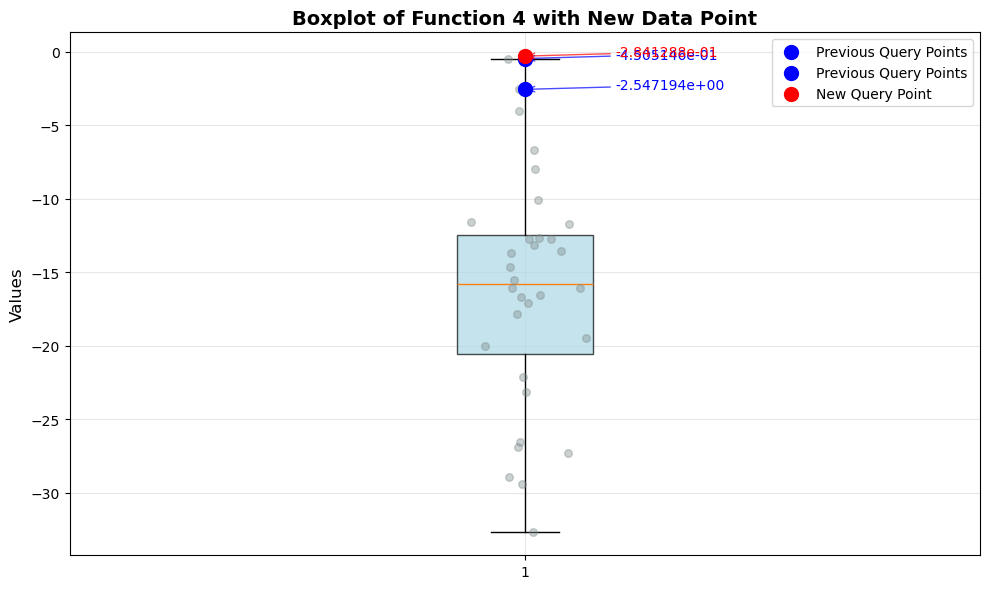

Old maximum: -4.505146e-01
New point: -2.841288e-01
Percentile rank in y_4: 100.0%

Old position: [0.346939 0.408163 0.469388 0.428571]
New position: [0.390749 0.37994  0.454619 0.42419 ]


In [118]:

plot_boxplot_with_new_point(
    y_4, 
    [y_new[3]], 
    np.array([y_4[-2], y_4[-1]]), 
    'Boxplot of Function 4 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_4):.6e}")
print(f"New point: {y_new[3]:.6e}")
print(f"Percentile rank in y_4: {100 * (y_4 < y_new[3]).sum() / len(y_4):.1f}%")
print(f"\nOld position: {x_4[np.argmax(y_4)]}")
print(f"New position: {x_new[3]}")

### Function 5

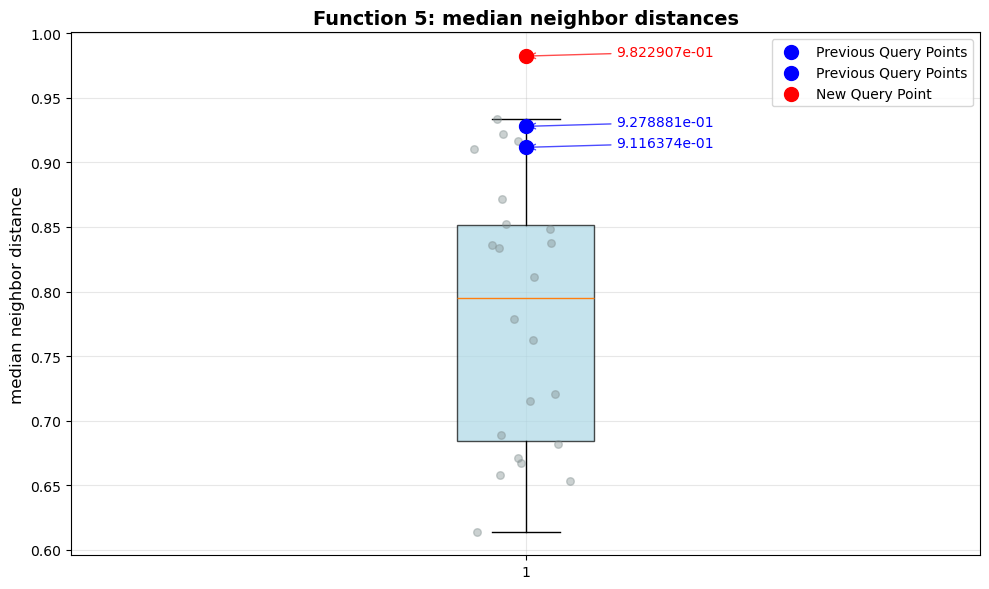

In [110]:
x5_distances = find_median_neighbor_distances(np.array(x_5))
new_x5_distance = np.array([find_median_distance_to_array(x_new[4], np.array(x_5))])
old_x5_distance = np.array([find_median_distance_to_array(x_5[-2], np.array(x_5)), find_median_distance_to_array(x_5[-1], np.array(x_5))])

plot_boxplot_with_new_point(
    x5_distances, 
    new_x5_distance,
    old_x5_distance, 
    'Function 5: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

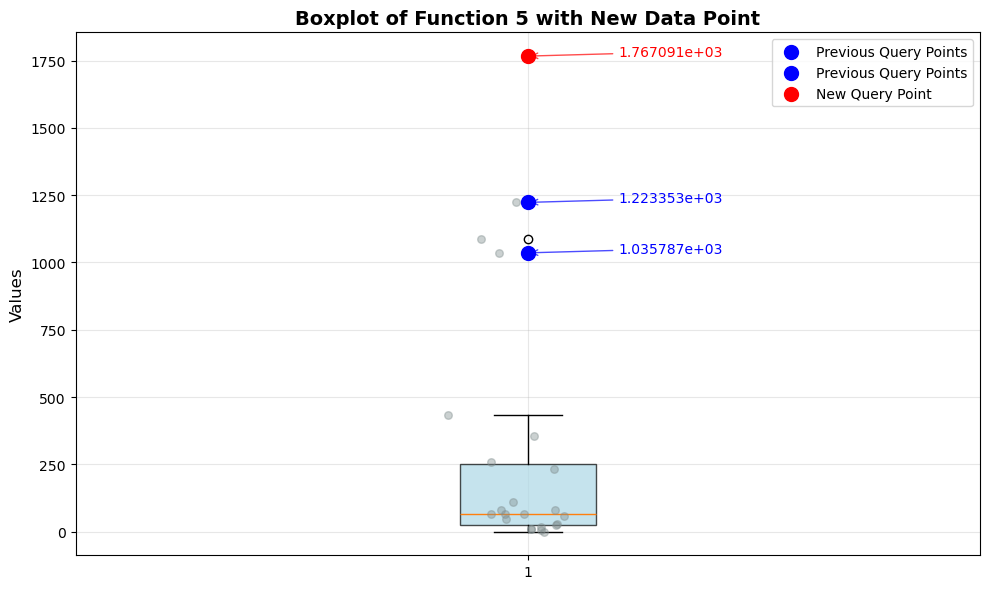

Old maximum: 1.223353e+03
New point: 1.767091e+03
Percentile rank in y_5: 100.0%

Old position: [0.22449  0.857143 0.897959 0.877551]
New position: [0.185689 0.876142 0.938525 0.91133 ]


In [119]:

plot_boxplot_with_new_point(
    y_5, 
    [y_new[4]], 
    np.array([y_5[-2], y_5[-1]]), 
    'Boxplot of Function 5 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_5):.6e}")
print(f"New point: {y_new[4]:.6e}")
print(f"Percentile rank in y_5: {100 * (y_5 < y_new[4]).sum() / len(y_5):.1f}%")
print(f"\nOld position: {x_5[np.argmax(y_5)]}")
print(f"New position: {x_new[4]}")

### Function 6

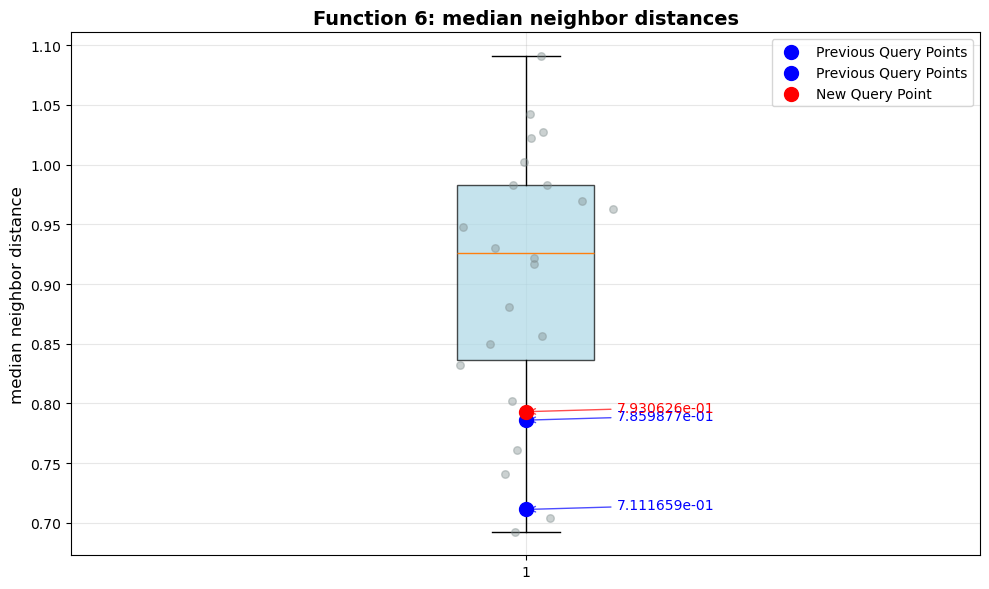

In [111]:
x6_distances = find_median_neighbor_distances(np.array(x_6))
new_x6_distance = np.array([find_median_distance_to_array(x_new[5], np.array(x_6))])
old_x6_distance = np.array([find_median_distance_to_array(x_6[-2], np.array(x_6)), find_median_distance_to_array(x_6[-1], np.array(x_6))])

plot_boxplot_with_new_point(
    x6_distances, 
    new_x6_distance,
    old_x6_distance, 
    'Function 6: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

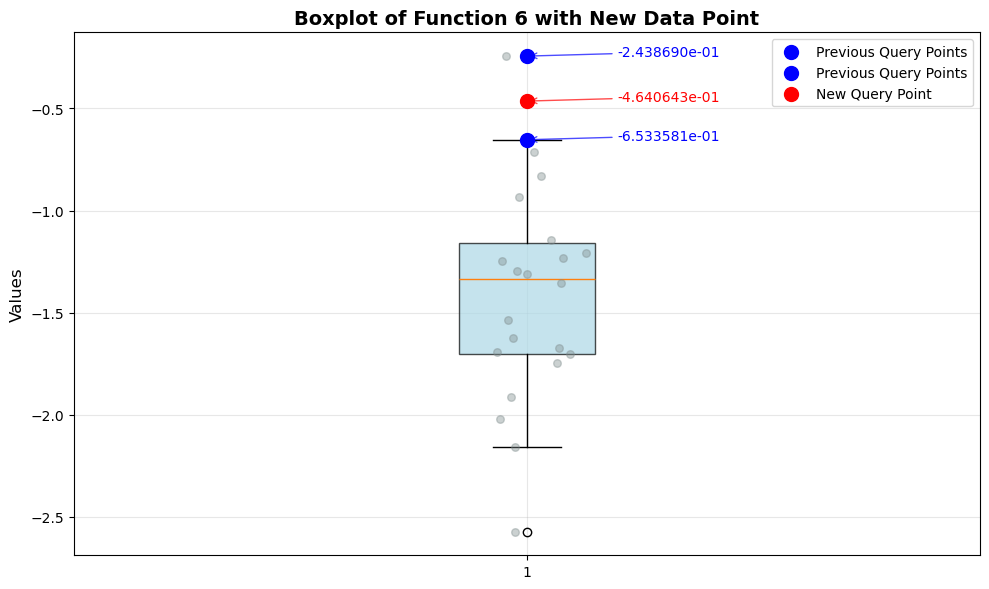

Old maximum: -2.438690e-01
New point: -4.640643e-01
Percentile rank in y_6: 95.5%

Old position: [0.482759 0.344828 0.551724 0.655172 0.137931]
New position: [0.38021  0.27319  0.561698 0.585146 0.007805]


In [120]:

plot_boxplot_with_new_point(
    y_6, 
    [y_new[5]], 
    np.array([y_6[-2], y_6[-1]]), 
    'Boxplot of Function 6 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_6):.6e}")
print(f"New point: {y_new[5]:.6e}")
print(f"Percentile rank in y_6: {100 * (y_6 < y_new[5]).sum() / len(y_6):.1f}%")
print(f"\nOld position: {x_6[np.argmax(y_6)]}")
print(f"New position: {x_new[5]}")

### Function 7

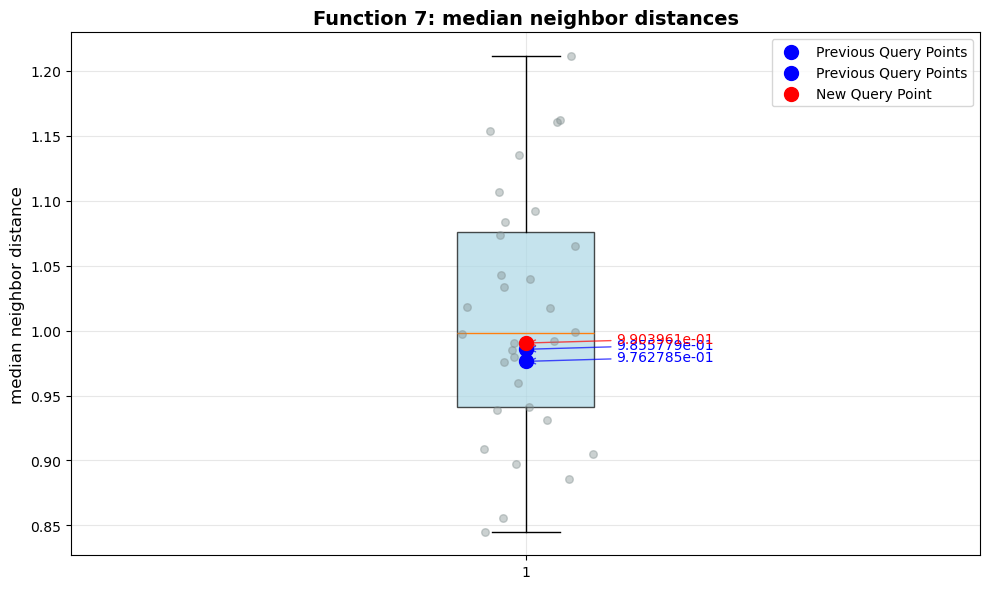

In [112]:
x7_distances = find_median_neighbor_distances(np.array(x_7))
new_x7_distance = np.array([find_median_distance_to_array(x_new[6], np.array(x_7))])
old_x7_distance = np.array([find_median_distance_to_array(x_7[-2], np.array(x_7)), find_median_distance_to_array(x_7[-1], np.array(x_7))])

plot_boxplot_with_new_point(
    x7_distances, 
    new_x7_distance,
    old_x7_distance, 
    'Function 7: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

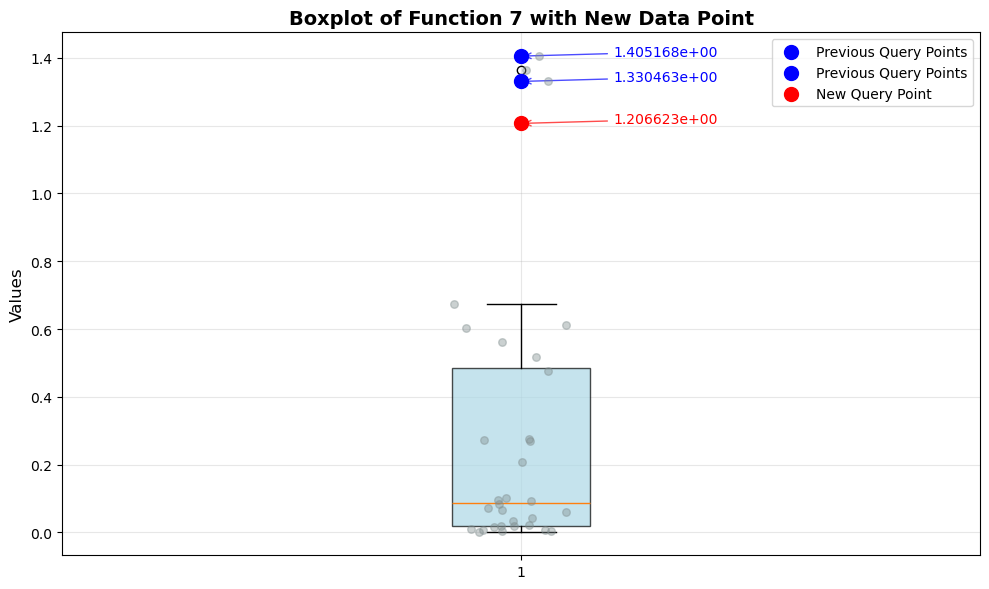

Old maximum: 1.405168e+00
New point: 1.206623e+00
Percentile rank in y_7: 90.6%

Old position: [0.       0.428571 0.285714 0.142857 0.357143 0.785714]
New position: [0.002921 0.380605 0.132162 0.112541 0.335804 0.806594]


In [121]:

plot_boxplot_with_new_point(
    y_7, 
    [y_new[6]], 
    np.array([y_7[-2], y_7[-1]]), 
    'Boxplot of Function 7 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_7):.6e}")
print(f"New point: {y_new[6]:.6e}")
print(f"Percentile rank in y_7: {100 * (y_7 < y_new[6]).sum() / len(y_7):.1f}%")
print(f"\nOld position: {x_7[np.argmax(y_7)]}")
print(f"New position: {x_new[6]}")

### Function 8

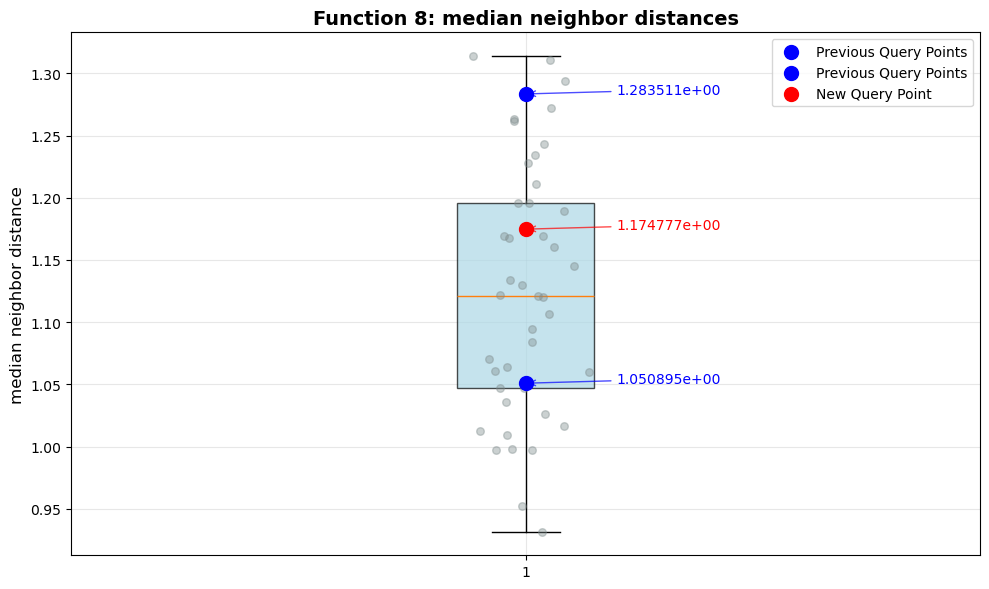

In [113]:
x8_distances = find_median_neighbor_distances(np.array(x_8))
new_x8_distance = np.array([find_median_distance_to_array(x_new[7], np.array(x_8))])
old_x8_distance = np.array([find_median_distance_to_array(x_8[-2], np.array(x_8)), find_median_distance_to_array(x_8[-1], np.array(x_8))])

plot_boxplot_with_new_point(
    x8_distances, 
    new_x8_distance,
    old_x8_distance, 
    'Function 8: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

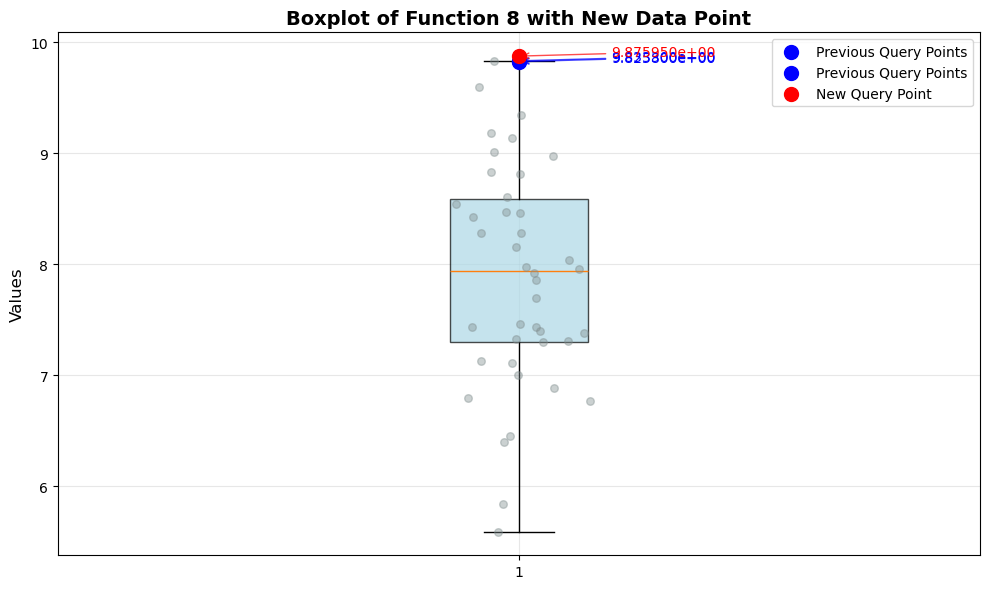

Old maximum: 9.833300e+00
New point: 9.875950e+00
Percentile rank in y_8: 100.0%

Old position: [0.25 0.25 0.   0.25 0.5  0.5  0.25 0.5 ]
New position: [0.018646 0.24367  0.003088 0.341666 0.765396 0.568567 0.258959 0.382488]


In [122]:

plot_boxplot_with_new_point(
    y_8, 
    [y_new[7]], 
    np.array([y_8[-2], y_8[-1]]), 
    'Boxplot of Function 8 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_8):.6e}")
print(f"New point: {y_new[7]:.6e}")
print(f"Percentile rank in y_8: {100 * (y_8 < y_new[7]).sum() / len(y_8):.1f}%")
print(f"\nOld position: {x_8[np.argmax(y_8)]}")
print(f"New position: {x_new[7]}")

# Add new data point

In [21]:
x_1 = np.concatenate((x_1, x_new[0].reshape(1, -1)))
y_1 = np.concatenate((y_1, np.array([y_new[0]])))

x_2 = np.concatenate((x_2, x_new[1].reshape(1, -1)))
y_2 = np.concatenate((y_2, np.array([y_new[1]])))

x_3 = np.concatenate((x_3, x_new[2].reshape(1, -1)))
y_3 = np.concatenate((y_3, np.array([y_new[2]])))

x_4 = np.concatenate((x_4, x_new[3].reshape(1, -1)))
y_4 = np.concatenate((y_4, np.array([y_new[3]])))

x_5 = np.concatenate((x_5, x_new[4].reshape(1, -1)))
y_5 = np.concatenate((y_5, np.array([y_new[4]])))

x_6 = np.concatenate((x_6, x_new[5].reshape(1, -1)))
y_6 = np.concatenate((y_6, np.array([y_new[5]])))

x_7 = np.concatenate((x_7, x_new[6].reshape(1, -1)))
y_7 = np.concatenate((y_7, np.array([y_new[6]])))

x_8 = np.concatenate((x_8, x_new[7].reshape(1, -1)))
y_8 = np.concatenate((y_8, np.array([y_new[7]])))


# Find new query points

## Function 1

In [83]:
# Fit GP

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.01
nu = 1.5

# set up evaluation grid:
x_11 = np.linspace(0, 1, 100)
x_12 = np.linspace(0, 1, 100)
x_11, x_12 = np.meshgrid(x_11, x_12)
x_1_grid = np.column_stack([x_11.ravel(), x_12.ravel()])

# Define and fit GP
kernel = Matern(length_scale = length_scale, nu = nu)
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True)
model.fit(np.array(x_1), np.array(y_1))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_1_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: -0.0003053637211401389
average posterior standard deviation: 0.0009555605056178242


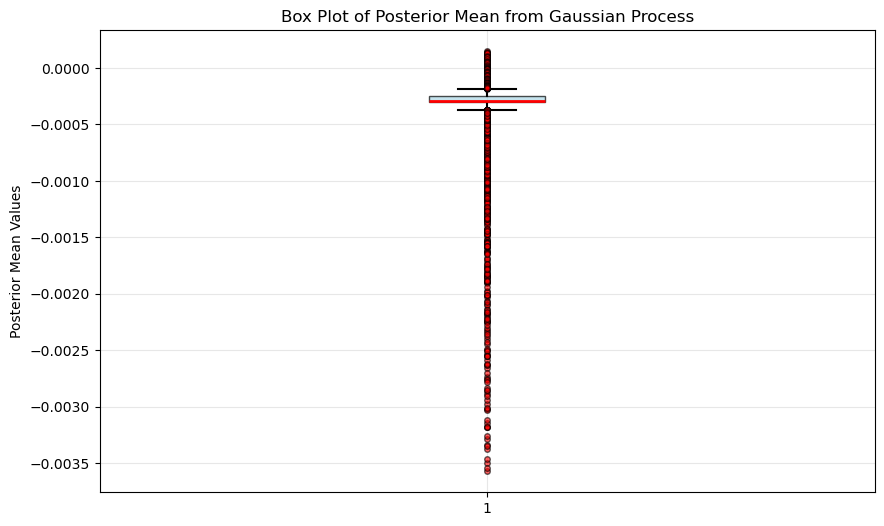

In [84]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

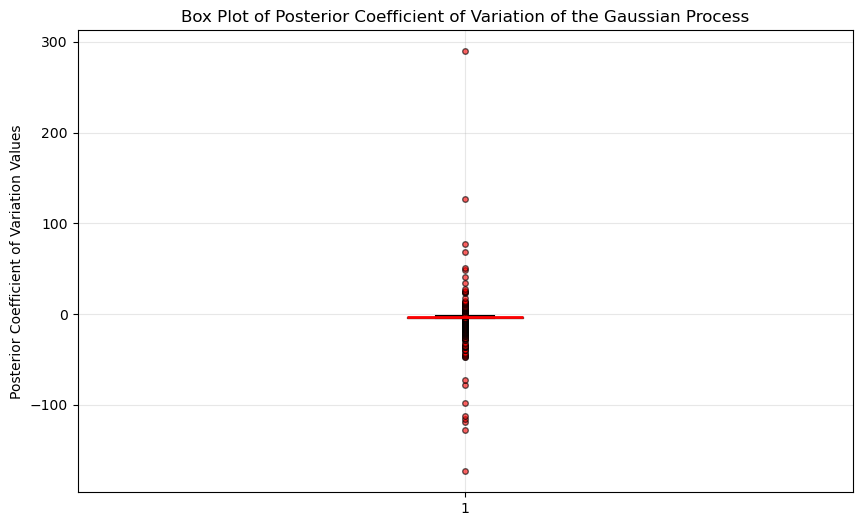

Median of the posterior coefficient of variation: -3.423097666346993


In [85]:
# Create density plot of post_mean
cv = post_std / post_mean
plot_boxplot(
    cv[np.argsort(cv)[:-2]], # need to remove the 2 highest values to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

print("Median of the posterior coefficient of variation:", np.median(cv))

The standard deviation is generally very high, so choose a $\kappa$ value higher than 1, giving slightly more weight to exploration.

In [90]:
# Calculate acquisition function

# Calculate the UCB aquisition function
kappa =  3
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_1 = np.argmax(UCB)  
next_point_1 = x_1_grid[max_idx_1] 
print("Best known point:", x_1[np.argmax(y_1)])
print("Next query point:", round(next_point_1[0], 6), round(next_point_1[1], 6))

Best known point: [0.73102363 0.73299988]
Next query point: 0.646465 0.969697


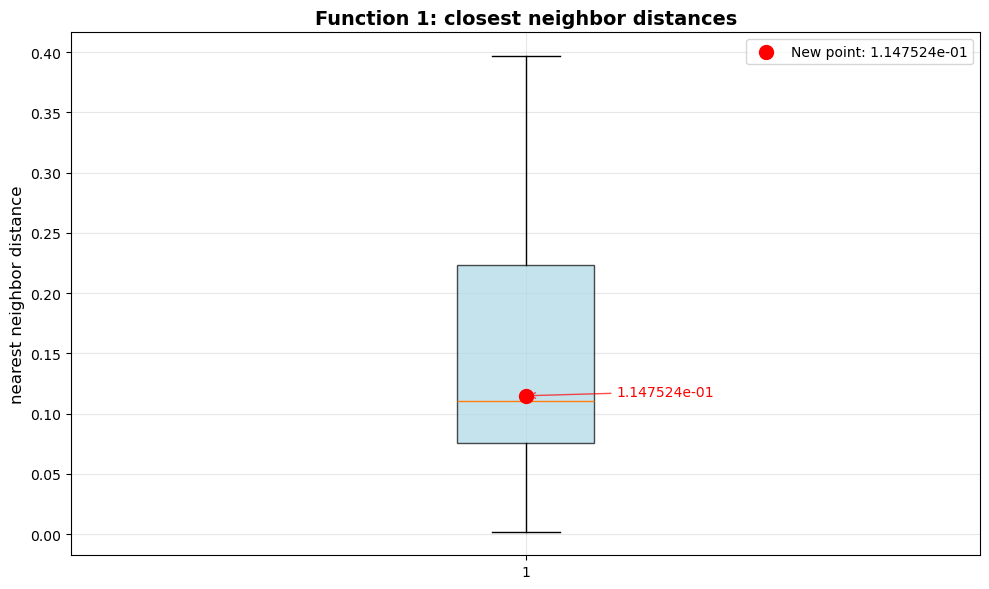

In [91]:
# check new distance compared to nearest neighbor distance
x1_distances = find_closest_neighbor_distances(np.array(x_1))
new_x1_distance = find_min_distance_to_array(next_point_1, np.array(x_1))
plot_boxplot_with_new_point(
    x1_distances, 
    new_x1_distance[0], 
    'Function 1: closest neighbor distances', 
    'nearest neighbor distance')

## Function 2

In [130]:
# GP assumption
noise_assumption = 1e-5

# kernel parameters
length_scale = 0.01
nu = 2

# set up evaluation grid:
x_21 = np.linspace(0, 1, 100)
x_22 = np.linspace(0, 1, 100)
x_21, x_22 = np.meshgrid(x_21, x_22)
x_2_grid = np.column_stack([x_21.ravel(), x_22.ravel()])

# Define and fit GP
kernel = Matern(length_scale = length_scale, nu = nu)
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True)
model.fit(np.array(x_2), np.array(y_2))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_2_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




average posterior mean: 0.1896115786147526
average posterior standard deviation: 0.22508005980927676


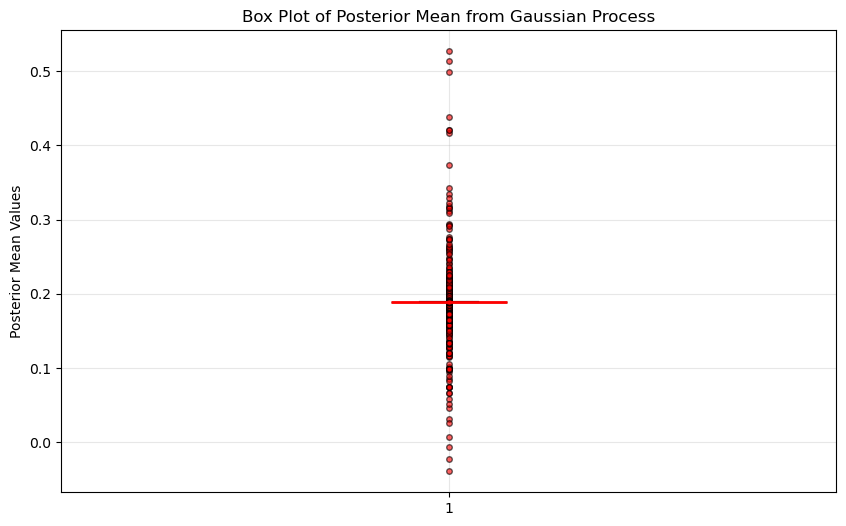

In [131]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

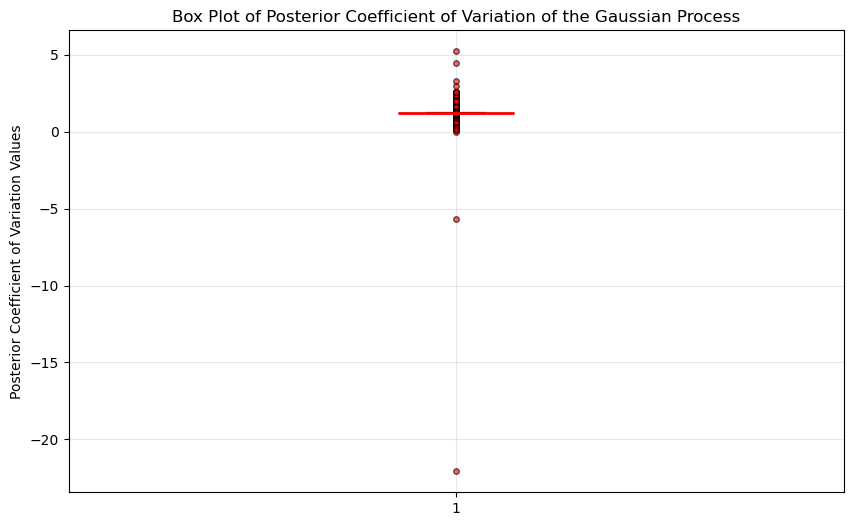

In [132]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

The standard deviation is relatively large, so I will choose a $\kappa$ value slightly greater than 1 to allow for slightly more exploration. 

In [137]:
# Calculate the UCB aquisition function
kappa =  1.5
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_2 = np.argmax(UCB)  
next_point_2 = x_2_grid[max_idx_2] 
print("Best known point:", x_2[np.argmax(y_2)])
print("Next query point:", round(next_point_2[0], 6), round(next_point_2[1], 6))

Best known point: [0.70263656 0.9265642 ]
Next query point: 0.707071 0.929293


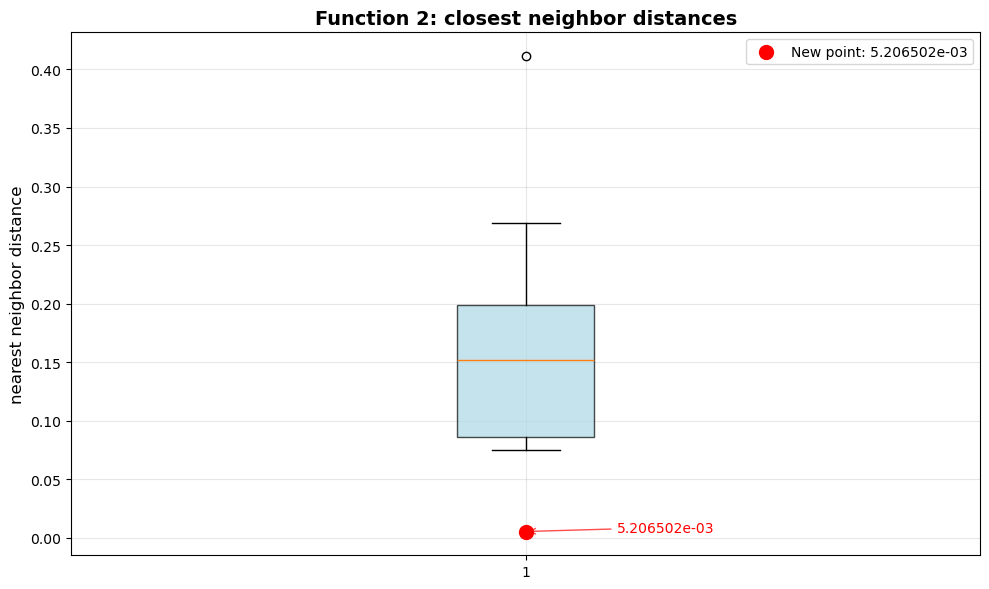

In [138]:
# check new distance compared to nearest neighbor distance
x2_distances = find_closest_neighbor_distances(np.array(x_2))
new_x2_distance = find_min_distance_to_array(next_point_2, np.array(x_2))
plot_boxplot_with_new_point(
    x2_distances, 
    new_x2_distance[0], 
    'Function 2: closest neighbor distances', 
    'nearest neighbor distance')

## Function 3

In [96]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_31 = np.linspace(0, 1, 100)
x_32 = np.linspace(0, 1, 100)
x_33 = np.linspace(0, 1, 100)
x_31, x_32, x_33 = np.meshgrid(x_31, x_32, x_33)
x_3_grid = np.column_stack([x_31.ravel(), x_32.ravel(), x_33.ravel()])

# Define and fit GP
#kernel = RBF(length_scale = length_scale) 
kernel = Matern(length_scale=length_scale, nu=nu) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_3), np.array(y_3))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_3_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))



average posterior mean: -0.10739249697201347
average posterior standard deviation: 0.06403327934813097


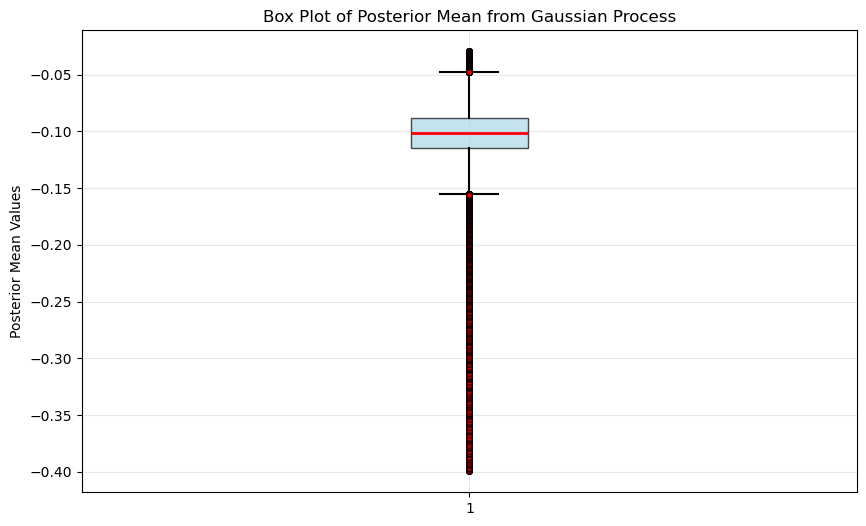

In [97]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

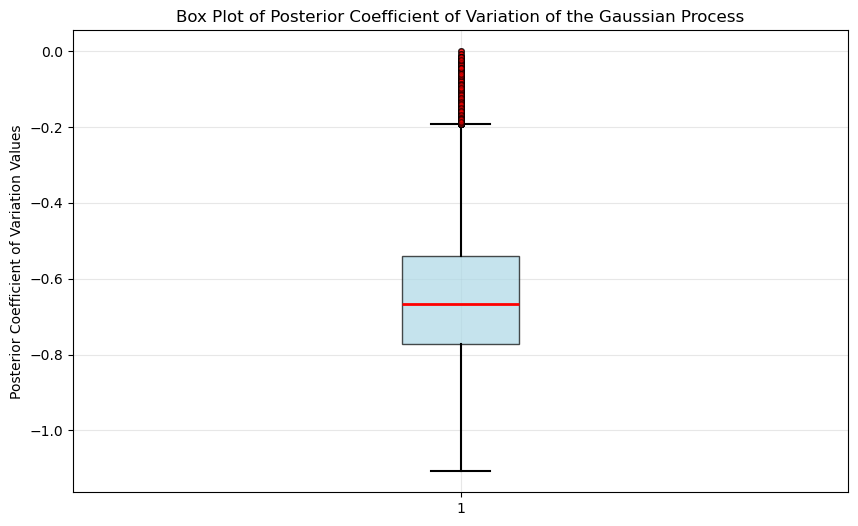

In [98]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

The standard deviation is generally very low (CV is mostly less than 1), so choose $\kappa$ so that exploration and exploitation are balanced. 

In [111]:

# Calculate the UCB aquisition function
kappa =  1
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_3 = np.argmax(UCB)  
next_point_3 = x_3_grid[max_idx_3] 
print("Best known point:", x_3[np.argmax(y_3)])
print("Next query point:", round(next_point_3[0], 6), round(next_point_3[1], 6), round(next_point_3[2], 6))


Best known point: [0.323232 0.282828 0.454545]
Next query point: 0.484848 0.767677 0.0


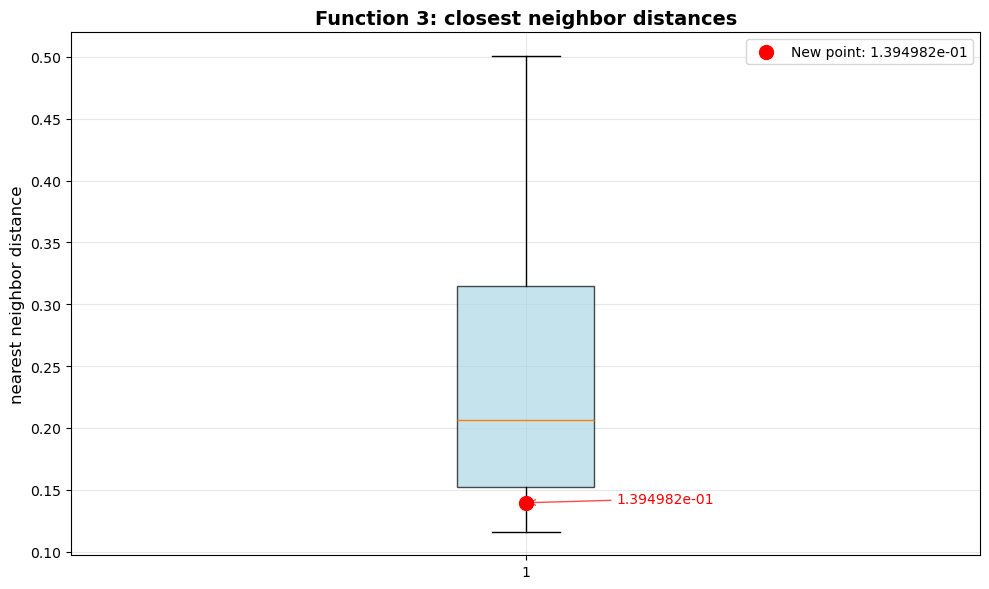

In [112]:
# check new distance compared to nearest neighbor distance
x3_distances = find_closest_neighbor_distances(np.array(x_3))
new_x3_distance = find_min_distance_to_array(next_point_3, np.array(x_3))
plot_boxplot_with_new_point(
    x3_distances, 
    new_x3_distance[0], 
    'Function 3: closest neighbor distances', 
    'nearest neighbor distance')

## Function 4

In [ ]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 2.5

x_4_grid = create_lhs_grid(n_samples=50**4, n_dimensions=4)

# Define and fit GP
kernel = Matern(length_scale=length_scale, nu=2.5)
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_4), np.array(y_4))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_4_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




average posterior mean: -16.724074587555435
average posterior standard deviation: 2.3274958848592333


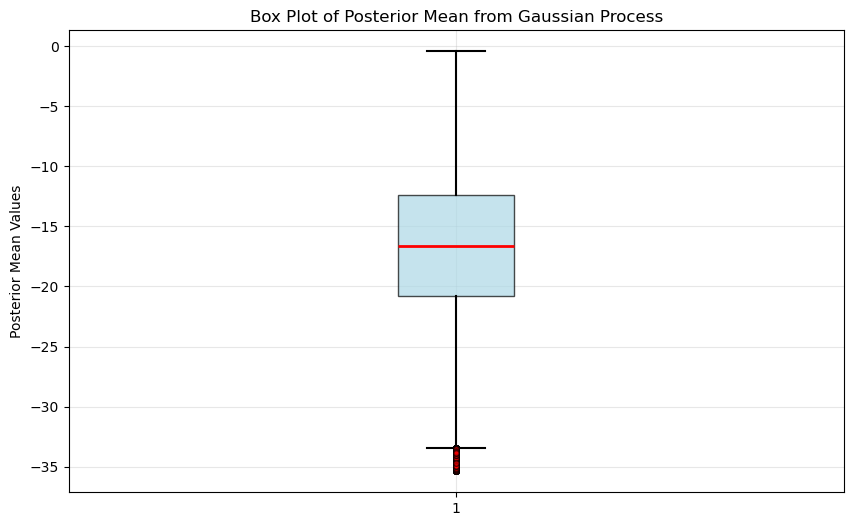

In [10]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

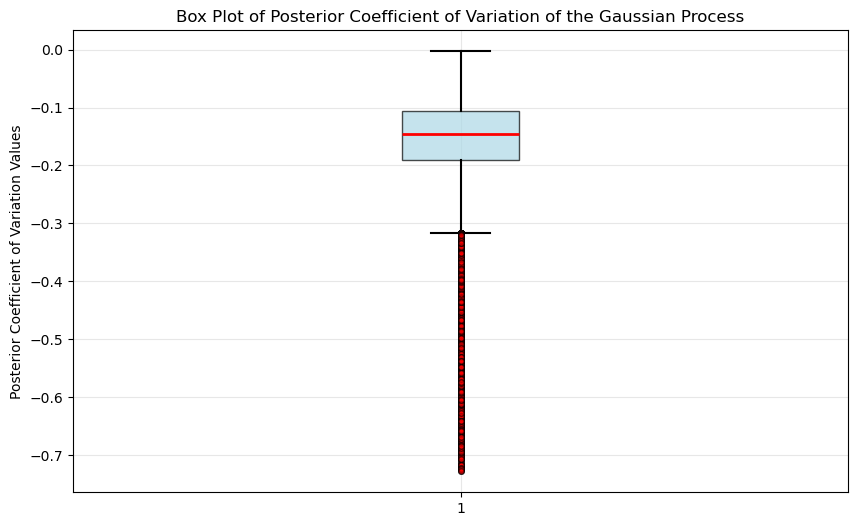

In [11]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

The CV is always between 1 and -1, so the standard deviation is relatively low. So, I set $\kappa$ to balance exploitation and exploration. 

In [18]:

# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean + kappa * post_std


# Get the next query point
max_idx_4 = np.argmax(UCB)  
next_point_4 = x_4_grid[max_idx_4] 
print("Best known point:", x_4[np.argmax(y_4)])
print("Next query point:", round(next_point_4[0], 6), round(next_point_4[1], 6), round(next_point_4[2], 6), round(next_point_4[3], 6))


Best known point: [0.346939 0.408163 0.469388 0.428571]
Next query point: 0.390749 0.37994 0.454619 0.42419


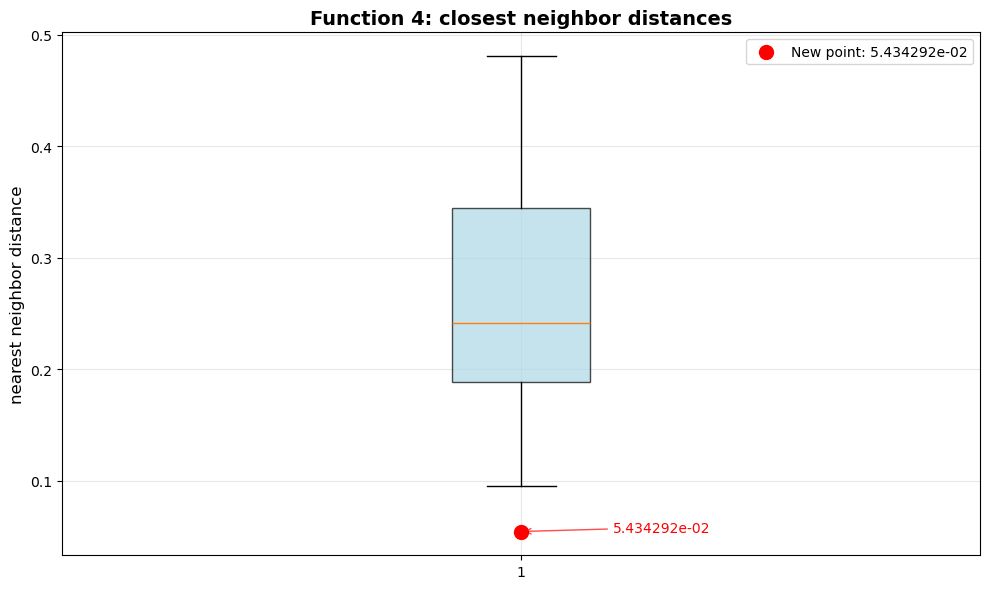

In [19]:
# check new distance compared to nearest neighbor distance
x4_distances = find_closest_neighbor_distances(np.array(x_4))
new_x4_distance = find_min_distance_to_array(next_point_4, np.array(x_4))
plot_boxplot_with_new_point(
    x4_distances, 
    new_x4_distance[0], 
    'Function 4: closest neighbor distances', 
    'nearest neighbor distance')

## Function 5

In [23]:

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1

# set up evaluation grid:
x_5_grid = create_lhs_grid(n_samples=50**4, n_dimensions=4)

# Define and fit GP
kernel = RBF(length_scale = length_scale) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_5), np.array(y_5))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_5_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




average posterior mean: 236.75747314375354
average posterior standard deviation: 365.08596245355596


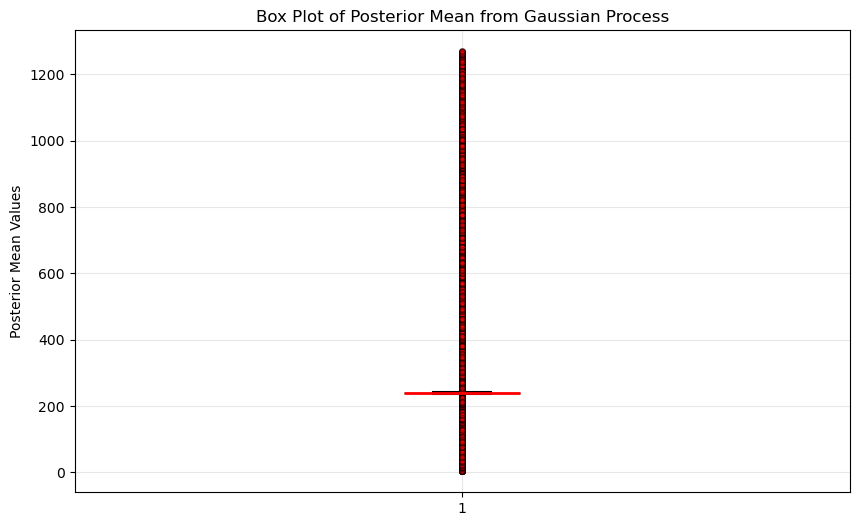

In [24]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

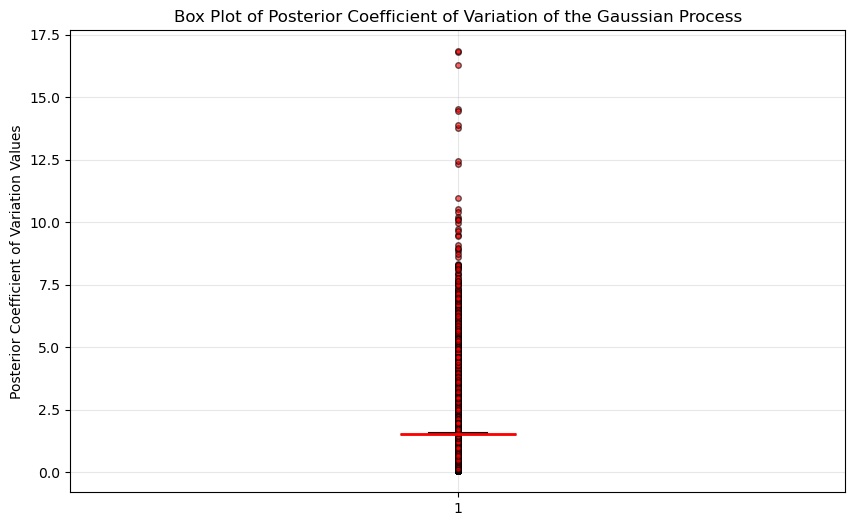

In [25]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

Standard deviation is relatively high, so choose a $\kappa$ slightly greater than one that puts more emphasis on exploration. 

In [32]:
# Calculate the UCB aquisition function
kappa = 2
UCB = post_mean + kappa * post_std


# Get the next query point
max_idx_5 = np.argmax(UCB)  
next_point_5 = x_5_grid[max_idx_5] 
print("Best known point:", x_5[np.argmax(y_5)])
print("Next query point:", round(next_point_5[0], 6), round(next_point_5[1], 6), round(next_point_5[2], 6), round(next_point_5[3], 6))

Best known point: [0.22449  0.857143 0.897959 0.877551]
Next query point: 0.185689 0.876142 0.938525 0.91133


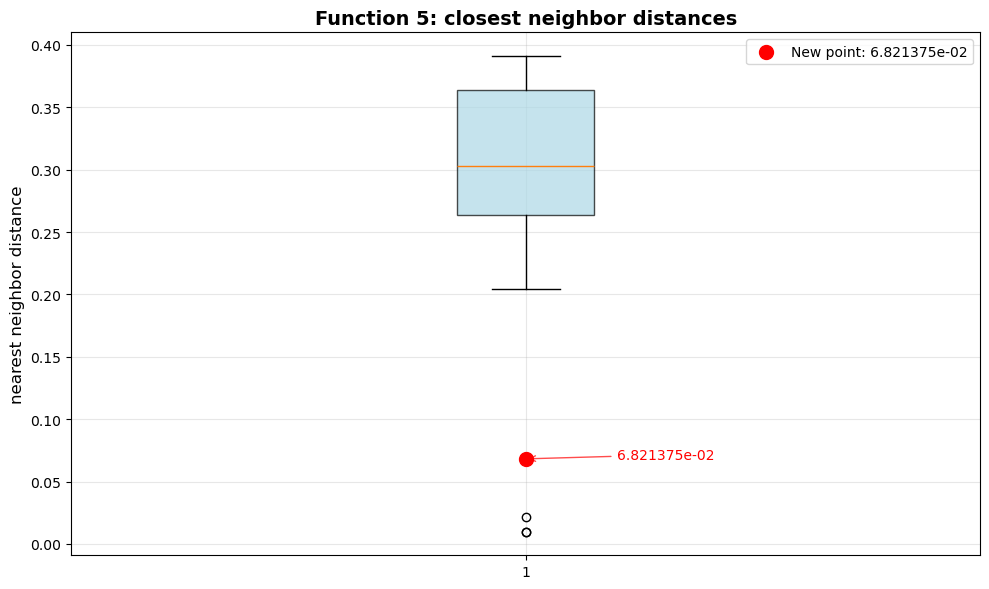

In [33]:
# check new distance compared to nearest neighbor distance
x5_distances = find_closest_neighbor_distances(np.array(x_5))
new_x5_distance = find_min_distance_to_array(next_point_5, np.array(x_5))
plot_boxplot_with_new_point(
    x5_distances, 
    new_x5_distance[0], 
    'Function 5: closest neighbor distances', 
    'nearest neighbor distance')

## Function 6

In [34]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1

# set up evaluation grid:
x_6_grid = create_lhs_grid(n_samples=30**5, n_dimensions=5)

# Define and fit GP
kernel = RBF(length_scale = length_scale) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_6), np.array(y_6))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_6_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: -1.4170303232945154
average posterior standard deviation: 0.3107929858164091


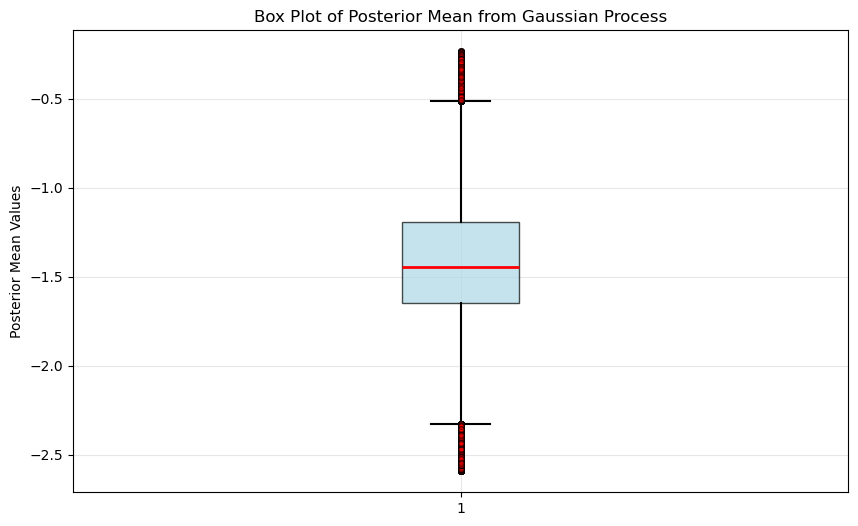

In [35]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

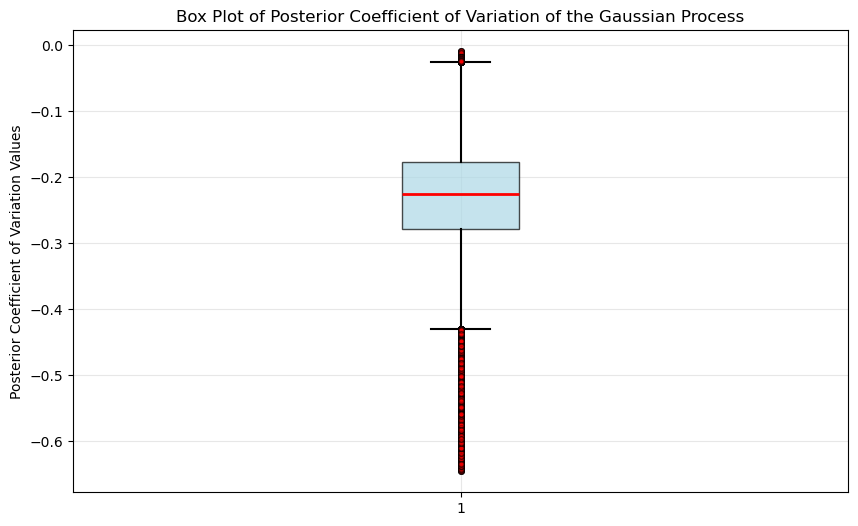

In [36]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

The standard deviation is relatively low, so choose $\kappa$ that balances exploration and exploitation.

In [37]:
# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_6 = np.argmax(UCB)  
next_point_6 = x_6_grid[max_idx_6] 
print("Best known point:", x_6[np.argmax(y_6)])
print("Next query point:", round(next_point_6[0], 6), round(next_point_6[1], 6), round(next_point_6[2], 6), round(next_point_6[3], 6), round(next_point_6[4], 6))

Best known point: [0.482759 0.344828 0.551724 0.655172 0.137931]
Next query point: 0.38021 0.27319 0.561698 0.585146 0.007805


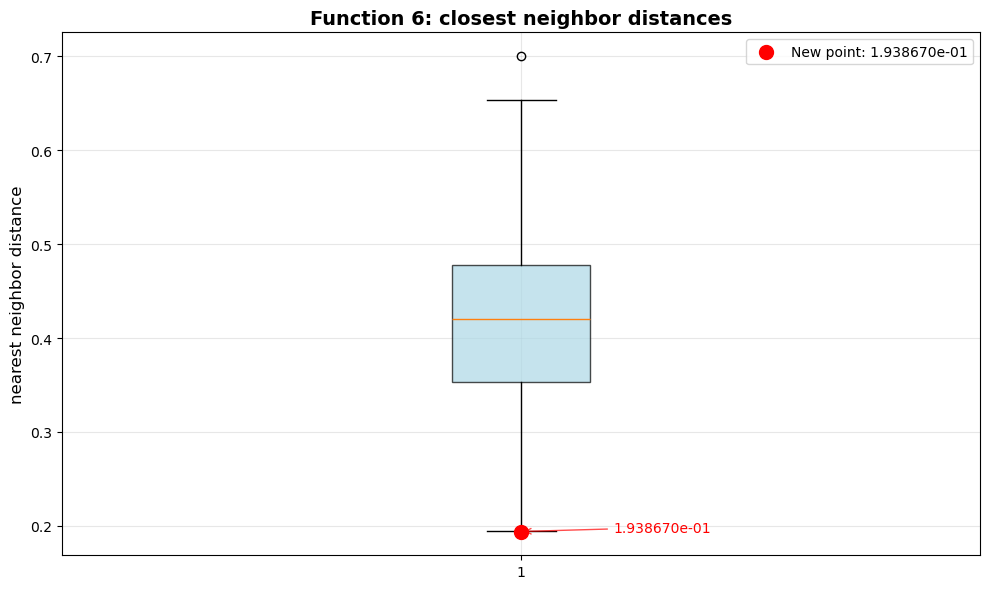

In [38]:
# check new distance compared to nearest neighbor distance
x6_distances = find_closest_neighbor_distances(np.array(x_6))
new_x6_distance = find_min_distance_to_array(next_point_6, np.array(x_6))
plot_boxplot_with_new_point(
    x6_distances, 
    new_x6_distance[0], 
    'Function 6: closest neighbor distances', 
    'nearest neighbor distance')

## Function 7

In [39]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_7_grid = create_lhs_grid(n_samples=15**6, n_dimensions=6)

# Define and fit GP
kernel = Matern(length_scale=length_scale, nu=nu) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_7), np.array(y_7))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_7_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: 0.2564546937640698
average posterior standard deviation: 0.29455806529545786


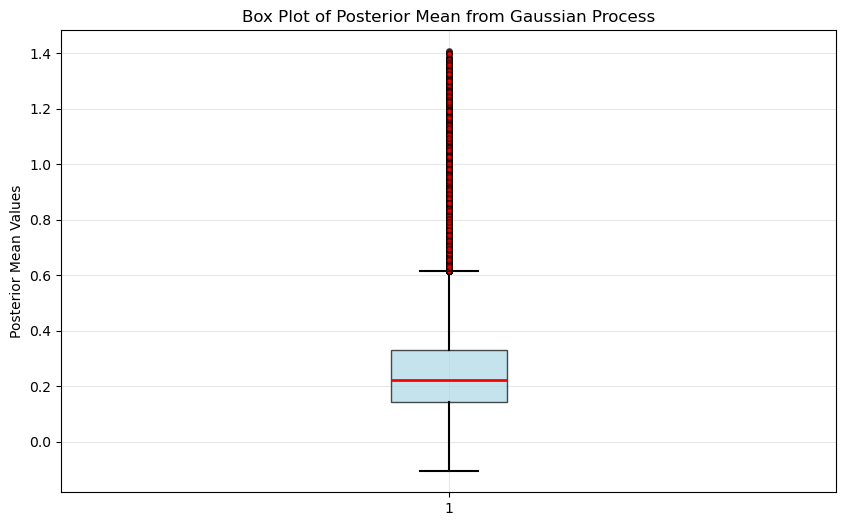

In [40]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [49]:
len(post_mean)

11390625

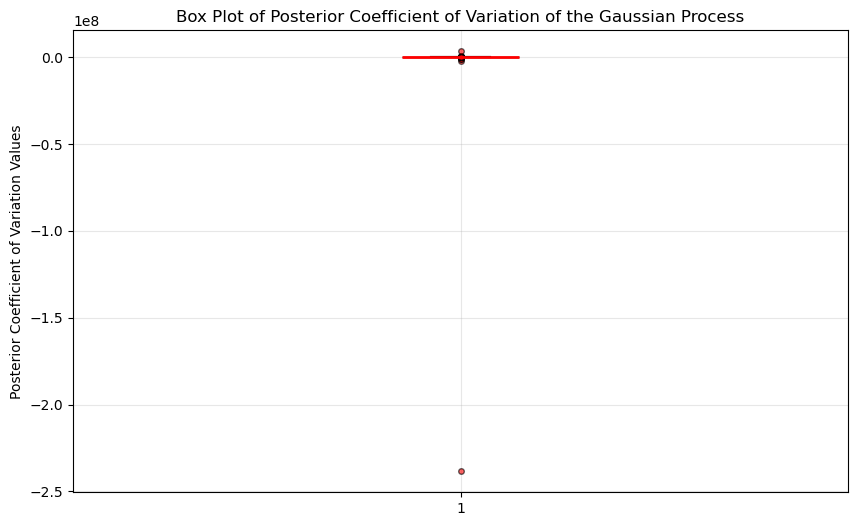

In [55]:

cv = post_std / post_mean
plot_boxplot(
    cv, # need to remove the highest value to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

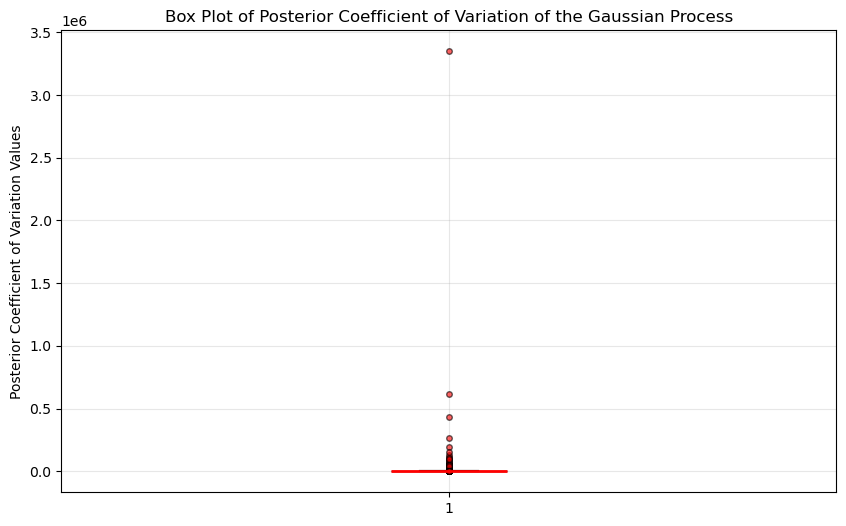

In [54]:

cv = post_std / post_mean
plot_boxplot(
    cv[cv > -2], # need to remove the highest value to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

In [61]:
len(cv[(cv >= -1) & (cv <= 1)])/len(cv)

0.30492602469135804

Most points have relatively high CVs, so choose a value for $\kappa$ slightly higher than 1. 

In [63]:
# Calculate the UCB aquisition function
kappa = 2
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_7 = np.argmax(UCB)  
next_point_7 = x_7_grid[max_idx_7] 
print("Best known point:", x_7[np.argmax(y_7)])
print("Next query point:", round(next_point_7[0], 6), round(next_point_7[1], 6), round(next_point_7[2], 6), round(next_point_7[3], 6), round(next_point_7[4], 6), round(next_point_7[5], 6))

Best known point: [0.       0.428571 0.285714 0.142857 0.357143 0.785714]
Next query point: 0.002921 0.380605 0.132162 0.112541 0.335804 0.806594


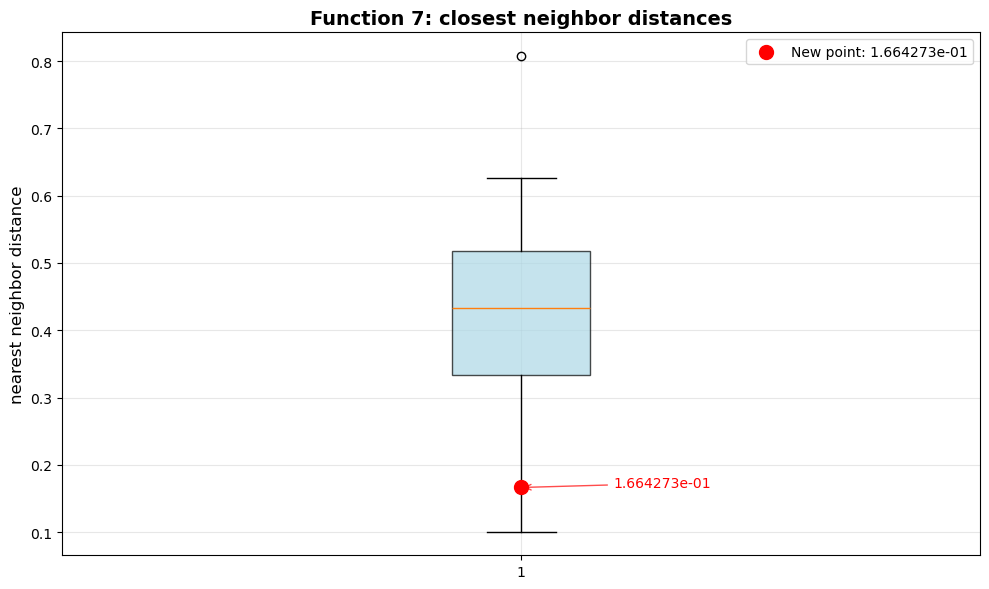

In [64]:
# check new distance compared to nearest neighbor distance
x7_distances = find_closest_neighbor_distances(np.array(x_7))
new_x7_distance = find_min_distance_to_array(next_point_7, np.array(x_7))
plot_boxplot_with_new_point(
    x7_distances, 
    new_x7_distance[0], 
    'Function 7: closest neighbor distances', 
    'nearest neighbor distance')

## Function 8

In [68]:

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_8_grid = create_lhs_grid(n_samples=8**8, n_dimensions=8)

# Define and fit GP
kernel = Matern(length_scale=length_scale, nu=nu) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_8), np.array(y_8))

# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_8_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: 7.986087859031671
average posterior standard deviation: 0.32313252608801


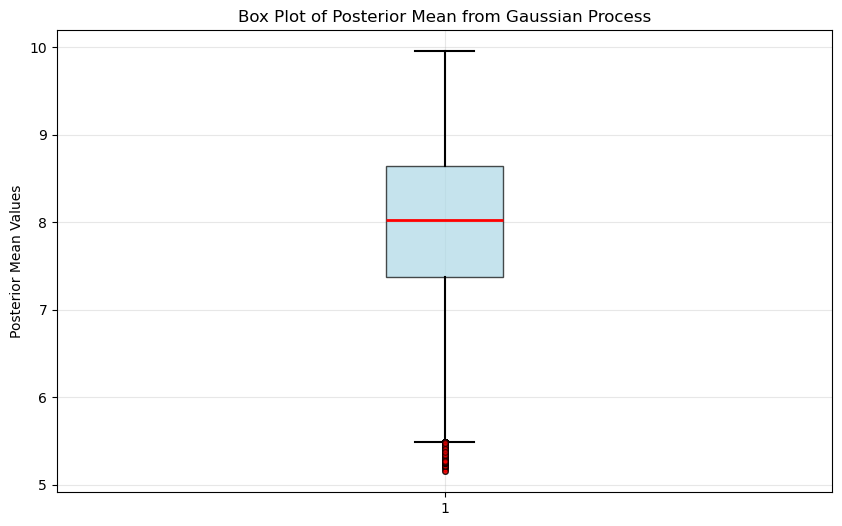

In [69]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

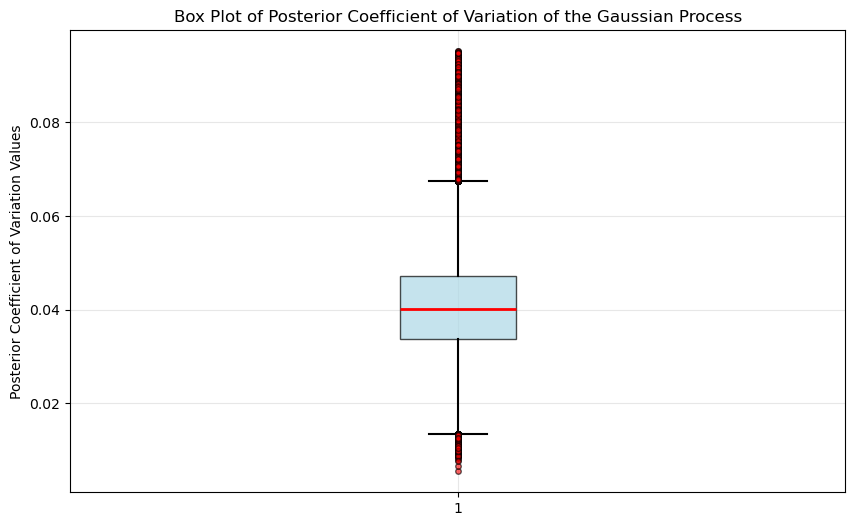

In [70]:

cv = post_std / post_mean
plot_boxplot(
    cv, # need to remove the highest value to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

The CV is extremely low, so I will choose a lower value for $\kappa$ that prioritises exploitation. 

In [81]:
# Calculate the UCB aquisition function
kappa = 0.8
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_8 = np.argmax(UCB)  
next_point_8 = x_8_grid[max_idx_8] 
print("Best known point:", x_8[np.argmax(y_8)])
print("Next query point:", round(next_point_8[0], 6), round(next_point_8[1], 6), round(next_point_8[2], 6), round(next_point_8[3], 6), round(next_point_8[4], 6), round(next_point_8[5], 6), round(next_point_8[6], 6), round(next_point_8[7], 6))


Best known point: [0.25 0.25 0.   0.25 0.5  0.5  0.25 0.5 ]
Next query point: 0.018646 0.24367 0.003088 0.341666 0.765396 0.568567 0.258959 0.382488


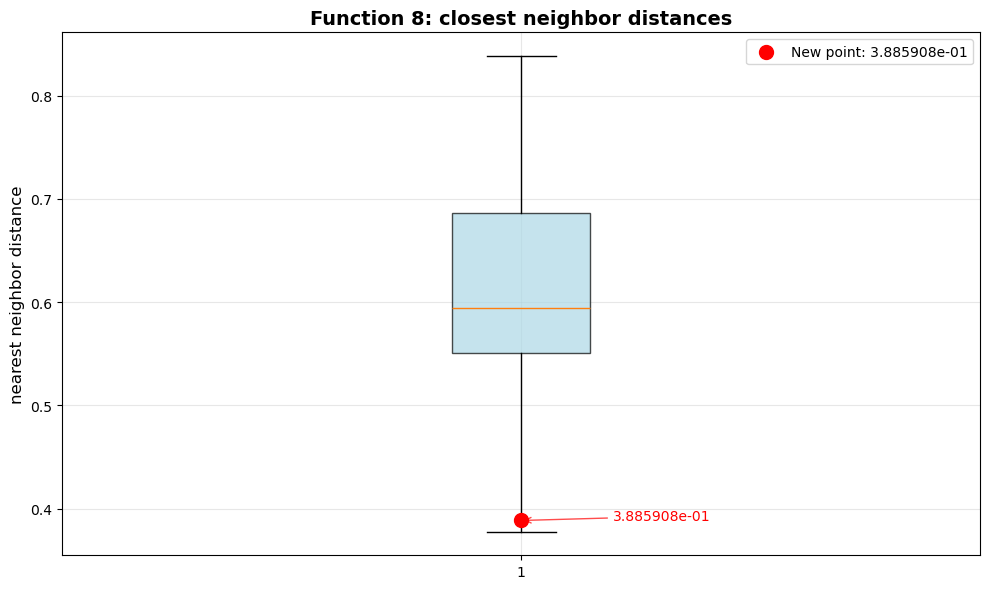

In [82]:
# check new distance compared to nearest neighbor distance
x8_distances = find_closest_neighbor_distances(np.array(x_8))
new_x8_distance = find_min_distance_to_array(next_point_8, np.array(x_8))
plot_boxplot_with_new_point(
    x8_distances, 
    new_x8_distance[0], 
    'Function 8: closest neighbor distances', 
    'nearest neighbor distance')